In [1]:
# Agar saat melakukan run ulang tidak memakan waktu yang terlalu lama
# maka EDA dan ML saya buat dalam 2 file terpisah

# Import Common Package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, classification_report, confusion_matrix

import imblearn
from imblearn.over_sampling import SMOTE

import joblib

In [2]:
# Mengakses data
df = pd.read_csv('online_shop.csv')
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


adapun keterangan dalam dataset tersebut adalah
- Administrative : Administrative Value
- Administrative_Duration : Duration in Administrative Page
- Informational : Informational Value
- Informational_Duration : Duration in Informational Page
- ProductRelated : Product Related Value
- ProductRelated_Duration : Duration in Product Related Page
- BounceRates : Bounce Rates of a web page
- ExitRates : Exit rate of a web page
- PageValues : Page values of each web page
- SpecialDay : Special days like valentine etc
- Month : Month of the year
- OperatingSystems : Operating system used
- Browser : Browser used
- Region : Region of the user
- TrafficType : Traffic Type
- VisitorType : Types of Visitor
- Weekend : Weekend or not
- Revenue : Revenue will be generated or not

In [3]:
# Pengecekan tabel data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
df['Weekend'] = df['Weekend'].astype(object)
df['Revenue'] = df['Revenue'].astype(object)

# Project Goals Machine Learning :
## Menemukan data pelanggan yang berpotensi menjadi pendapatan bagi online shop dan menemukan model terbaik untuk memprediksi pelanggan berpotensi menajdi pendapatan atau tidak bagi perusahaan

In [4]:
# Pengecekan data imbalance atau tidak
df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [5]:
pd.crosstab(index = df['Revenue'], columns='count', normalize=True)

col_0,count
Revenue,
False,0.845255
True,0.154745


Jadi, karena perbandingan di kolom target, dalam hal ini adalah kolom Revenue 85 : 15 maka dataset ini merupakan data **imbalance**. Data ini digunakan untuk memprediksi pelanggan yang berpotensi menjadi pendapatan bagi perusahan.
Kelas minoritas dalam data ini adalah pelanggan yang menjadi pendapatan bagi online shop

In [6]:
# Karena tidak ada missing value, maka kita langsung melakukan future engineering dan future selection
# Sebagai base model, semua variabel data akan digunakan
# sebagai data untuk base model, semua nilai tidak akan diganggu, hanya kolom kategorik yang akan diencode

df['Month'] = df['Month'].map({'Feb':2,'Mar':3,'May':5,'June':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12})
df['VisitorType'] = df['VisitorType'].map({'Returning_Visitor':2,'New_Visitor':1,'Other':0})

# Saat dilakukan def dan map menghasilkan NaN, jadi akan digunakan get_dummies
# def maping(x):
#     if x == 'False':
#         return 0
#     else:
#         return 1
# df['weekend'] = df['Weekend'].apply(maping)
# df['revenue'] = df['Revenue'].apply(maping)
    
# df['Weekend'] = df['Weekend'].map({'False':0,' True':1})
# df['Revenue'] = df['Revenue'].map({'False':0,' True':1})

df = pd.get_dummies(df,columns=['Weekend','Revenue'])

df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend_False,Weekend_True,Revenue_False,Revenue_True
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,2,1,0,1,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,2,1,0,1,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,2,1,0,1,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,2,1,0,1,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,2,0,1,1,0
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,2,0,1,1,0
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,2,0,1,1,0
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,2,1,0,1,0


In [7]:
# Kita akan menggunakan semua kolom kecuali kolom Weekend_False dan Revenue_False
df.drop(columns=['Weekend_False','Revenue_False'],inplace=True)
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend_True,Revenue_True
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,2,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,2,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,2,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,2,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,2,1,0
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,2,1,0
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,2,1,0
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,2,0,0


In [8]:
# Splitting Data
X = df.drop(columns='Revenue_True')
y = df['Revenue_True']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 42)

In [9]:
# Modeling data dengan LogReg
LR = LogisticRegression()

In [10]:
LR.fit(X_train, y_train)

LogisticRegression()

In [11]:
y_predLR = LR.predict(X_test)

In [12]:
# Melakukan Evaluation Matrix
print(classification_report(y_test, y_predLR))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2084
           1       0.70      0.37      0.49       382

    accuracy                           0.88      2466
   macro avg       0.80      0.67      0.71      2466
weighted avg       0.86      0.88      0.86      2466



In [13]:
cm_LR = confusion_matrix(y_test, y_predLR, labels=[1, 0])

In [14]:
df_LR = pd.DataFrame(cm_LR, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_LR

,Pred 1,Pred 0
Akt 1,142,240
Akt 0,60,2024


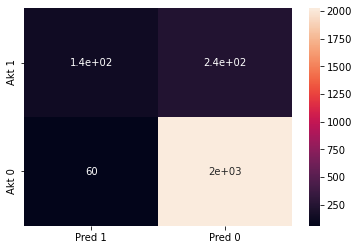

In [15]:
sns.heatmap(df_LR, annot=True)
plt.show()

Insight : karena kita menginginkan model dengan nilai FP (false positif) yang rendah (kita memprediksi pelanggan tersebut adalah pelanggan berpotensi tetapi pada kenyataannya bukan), maka berdasarkan model machine learning logistic regresion didapat data yang cukup bagus. Karena kita menginginkan FP yang rendah maka kita mencari model dengan nilai precision yang besar

In [16]:
# Modeling Data dengan RandomForest
RF = RandomForestClassifier()

In [17]:
RF.fit(X_train,y_train)

RandomForestClassifier()

In [18]:
y_predRF = RF.predict(X_test)

In [19]:
# Melakukan Evaluation Matrix
print(classification_report(y_test, y_predRF))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2084
           1       0.71      0.55      0.62       382

    accuracy                           0.90      2466
   macro avg       0.82      0.75      0.78      2466
weighted avg       0.89      0.90      0.89      2466



In [20]:
cm_RF = confusion_matrix(y_test, y_predRF, labels=[1, 0])

In [21]:
df_RF = pd.DataFrame(cm_RF, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_RF

,Pred 1,Pred 0
Akt 1,210,172
Akt 0,85,1999


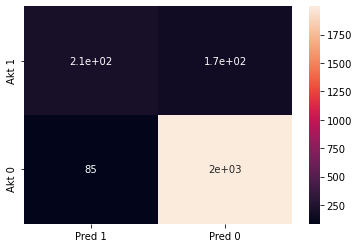

In [22]:
sns.heatmap(df_RF, annot=True)
plt.show()

Insight : Model RF menghasilkan nilai precision yang lebih baik sedikit dari LogReg namun FPnya lebih besar. saat ini lebih prefer menggunakan LogReg sebagai model

In [23]:
# Modeling Data dengan Decision Tree
DT = DecisionTreeClassifier()

In [24]:
DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
y_predDT = DT.predict(X_test)

In [26]:
# Melakukan Evaluation Matrix
print(classification_report(y_test, y_predDT))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2084
           1       0.52      0.51      0.51       382

    accuracy                           0.85      2466
   macro avg       0.72      0.71      0.71      2466
weighted avg       0.85      0.85      0.85      2466



In [27]:
cm_DT = confusion_matrix(y_test, y_predDT, labels=[1, 0])

In [28]:
df_DT = pd.DataFrame(cm_DT, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_DT

,Pred 1,Pred 0
Akt 1,194,188
Akt 0,179,1905


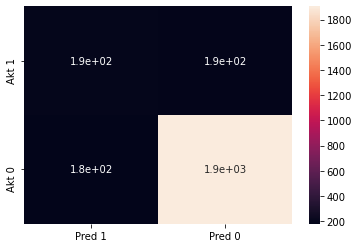

In [29]:
sns.heatmap(df_DT, annot=True)
plt.show()

Insight : Nilai precision dari model Decision Tree lebih rendah dari model lainnya, nilai FP juga lebih besar dari model lainnya sehingga model ini kurang baik digunakan.

# Melakukan Hyper Parameter Tuning

In [30]:
## Hyper Parameter Tuning
skf = StratifiedKFold(n_splits=3)

In [31]:
# Model LogReg untuk HyperParameterTuning
LR_Tuned = LogisticRegression()

In [32]:
param_LR = {
    'C' : np.logspace(-3 , 3, 7),
    "penalty" : ['l1', 'l2', 'elasticnet']
}

In [33]:
GS_LR = GridSearchCV(LR_Tuned, param_LR, cv = skf, n_jobs=-1, verbose =1)

In [34]:
GS_LR.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    7.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             verbose=1)

In [35]:
GS_LR.best_params_

{'C': 1000.0, 'penalty': 'l2'}

In [36]:
LR_Tuned = GS_LR.best_estimator_

In [37]:
LR_Tuned.fit(X_train, y_train)

LogisticRegression(C=1000.0)

In [38]:
y_predLR_Tuned = LR_Tuned.predict(X_test)

In [39]:
# Melakukan Evaluation Matrix
print(classification_report(y_test, y_predLR_Tuned))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2084
           1       0.69      0.36      0.47       382

    accuracy                           0.88      2466
   macro avg       0.79      0.67      0.70      2466
weighted avg       0.86      0.88      0.86      2466



In [40]:
cm_LR_Tuned = confusion_matrix(y_test, y_predLR_Tuned, labels=[1, 0])

In [41]:
df_LR_Tuned = pd.DataFrame(cm_LR_Tuned, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_LR_Tuned

,Pred 1,Pred 0
Akt 1,138,244
Akt 0,62,2022


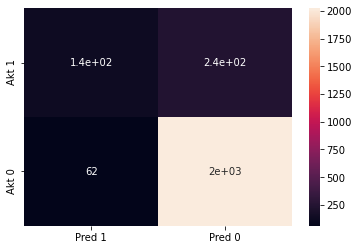

In [42]:
sns.heatmap(df_LR_Tuned, annot=True)
plt.show()

Insight : Model LogReg yang sudah di-hyper parameter tuning ini tidak lebih baik dari model LogReg sebelumnya yang tidak dihyperparametertuning.

In [43]:
# Model RF untuk HyperParameterTuning
RF_Tuned = RandomForestClassifier()

In [44]:
param_RF = {
    "n_estimators" : np.arange(100, 501, 100),
    "max_depth" : [None, 5, 10, 15],
    "min_samples_leaf" : np.arange(1, 17, 5),
    "max_features" : [0.3, 0.5, 0.7, 0.8]
}

In [45]:
GS_RF = GridSearchCV(RF_Tuned, param_RF, cv = skf, n_jobs=-1, verbose =1)

In [46]:
GS_RF.fit(X_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 19.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'max_features': [0.3, 0.5, 0.7, 0.8],
                         'min_samples_leaf': array([ 1,  6, 11, 16]),
                         'n_estimators': array([100, 200, 300, 400, 500])},
             verbose=1)

In [47]:
GS_RF.best_params_

{'max_depth': None,
 'max_features': 0.8,
 'min_samples_leaf': 11,
 'n_estimators': 100}

In [48]:
RF_Tuned = GS_RF.best_estimator_

In [49]:
RF_Tuned = GS_RF.best_estimator_

In [50]:
y_predRF_Tuned = RF_Tuned.predict(X_test)

In [51]:
# Melakukan Evaluation Matrix
print(classification_report(y_test, y_predRF_Tuned))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2084
           1       0.72      0.58      0.65       382

    accuracy                           0.90      2466
   macro avg       0.82      0.77      0.79      2466
weighted avg       0.89      0.90      0.90      2466



In [52]:
cm_RF_Tuned = confusion_matrix(y_test, y_predRF_Tuned, labels=[1, 0])

In [53]:
df_RF_Tuned = pd.DataFrame(cm_RF_Tuned, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_RF_Tuned

,Pred 1,Pred 0
Akt 1,223,159
Akt 0,86,1998


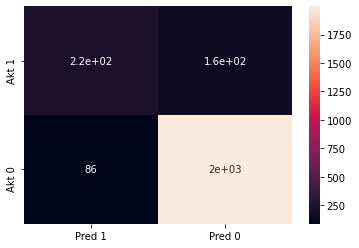

In [54]:
sns.heatmap(df_RF_Tuned, annot=True)
plt.show()

Insight : Model RF yang sudah di-hyper parameter tuning ini sedikit lebih buruk dari model RF sebelumnya yang tidak dihyperparametertuning walaupun nilai precisionnya lebih meningkat.

In [55]:
# Model DT untuk HyperParameterTuning
DT_Tuned = DecisionTreeClassifier()

In [56]:
param_DT = {
    "max_depth" : [None, 5, 10, 15],
    "min_samples_leaf" : np.arange(1, 20, 5),
    "max_features" : np.arange(0, 1.1, 0.3)
}

In [57]:
GS_DT = GridSearchCV(DT_Tuned, param_DT, cv = skf, n_jobs=-1, verbose =1)

In [58]:
GS_DT.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    1.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'max_features': array([0. , 0.3, 0.6, 0.9]),
                         'min_samples_leaf': array([ 1,  6, 11, 16])},
             verbose=1)

In [59]:
GS_DT.best_params_

{'max_depth': 5, 'max_features': 0.8999999999999999, 'min_samples_leaf': 16}

In [60]:
DT_Tuned = GS_DT.best_estimator_

In [61]:
DT_Tuned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features=0.8999999999999999,
                       min_samples_leaf=16)

In [62]:
y_predDT_Tuned = DT_Tuned.predict(X_test)

In [63]:
# Melakukan Evaluation Matrix
print(classification_report(y_test, y_predDT_Tuned))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2084
           1       0.71      0.59      0.64       382

    accuracy                           0.90      2466
   macro avg       0.82      0.77      0.79      2466
weighted avg       0.89      0.90      0.89      2466



In [64]:
cm_DT_Tuned = confusion_matrix(y_test, y_predDT_Tuned, labels=[1, 0])

In [65]:
df_DT_Tuned = pd.DataFrame(cm_DT_Tuned, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_DT_Tuned

,Pred 1,Pred 0
Akt 1,226,156
Akt 0,94,1990


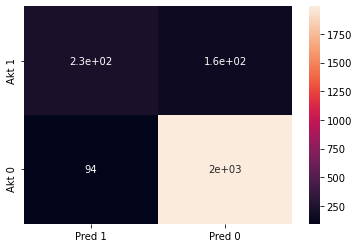

In [66]:
sns.heatmap(df_DT_Tuned, annot=True)
plt.show()

Insight : Model DT yang sudah di-hyper parameter tuning ini jauh lebih baik dari model DT sebelumnya yang tidak dihyperparametertuning namun tidak lebih baik dari model LogReg yang tidak dihyperparametertuning.

# Melakukan Handling Imbalanced Data dengan menggunakan Class Weight

In [67]:
# Modeling Machine Learning dengan menggunakan model LogReg dan mengatur Class Weight
LR_CW = LogisticRegression(class_weight={0 : .02, 1 : .98})

In [68]:
LR_CW.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.02, 1: 0.98})

In [69]:
y_predCW = LR_CW.predict(X_test)

In [70]:
# Melakukan Evaluation Matrix
print(classification_report(y_test, y_predCW))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36      2084
           1       0.19      1.00      0.32       382

    accuracy                           0.34      2466
   macro avg       0.60      0.61      0.34      2466
weighted avg       0.87      0.34      0.36      2466



In [71]:
cm_CW = confusion_matrix(y_test, y_predCW, labels=[1, 0])

In [72]:
df_CW = pd.DataFrame(cm_CW, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_CW

,Pred 1,Pred 0
Akt 1,382,0
Akt 0,1621,463


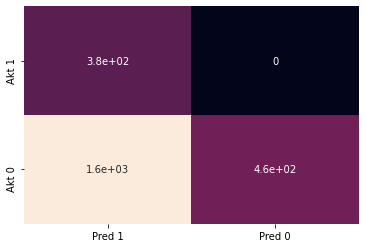

In [73]:
sns.heatmap(df_CW, annot=True, cbar=False)
plt.show()

Insight : Model LogReg yang sudah di-classweight ini tidak lebih baik dari model LogReg polos.

In [74]:
# Modeling Machine Learning dengan menggunakan model RF dan mengatur Class Weight
RF_CW = RandomForestClassifier(class_weight={0 : .02, 1 : .98})

In [75]:
RF_CW.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.02, 1: 0.98})

In [76]:
y_pred_RF_CW = RF_CW.predict(X_test)

In [77]:
# Melakukan Evaluation Matrix
print(classification_report(y_test, y_pred_RF_CW))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2084
           1       0.73      0.49      0.58       382

    accuracy                           0.89      2466
   macro avg       0.82      0.73      0.76      2466
weighted avg       0.88      0.89      0.88      2466



In [78]:
cm_RF_CW = confusion_matrix(y_test, y_pred_RF_CW, labels=[1, 0])

In [79]:
df_RF_CW = pd.DataFrame(cm_RF_CW, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_RF_CW

,Pred 1,Pred 0
Akt 1,186,196
Akt 0,69,2015


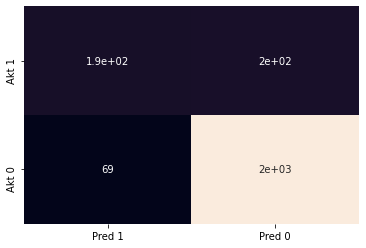

In [80]:
sns.heatmap(df_RF_CW, annot=True, cbar=False)
plt.show()

Insight : Model RF Class-Weight memiliki nilai yang samma dengan model RF polos.

In [81]:
# Modeling Machine Learning dengan menggunakan model DT dan mengatur Class Weight
DT_CW = DecisionTreeClassifier(class_weight={0 : .02, 1 : .98})

In [82]:
DT_CW.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.02, 1: 0.98})

In [83]:
y_pred_DT_CW = DT_CW.predict(X_test)

In [84]:
# Melakukan Evaluation Matrix
print(classification_report(y_test, y_pred_DT_CW))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2084
           1       0.55      0.50      0.52       382

    accuracy                           0.86      2466
   macro avg       0.73      0.71      0.72      2466
weighted avg       0.85      0.86      0.86      2466



In [85]:
cm_DT_CW = confusion_matrix(y_test, y_pred_DT_CW, labels=[1, 0])

In [86]:
df_DT_CW = pd.DataFrame(cm_DT_CW, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_DT_CW

,Pred 1,Pred 0
Akt 1,190,192
Akt 0,156,1928


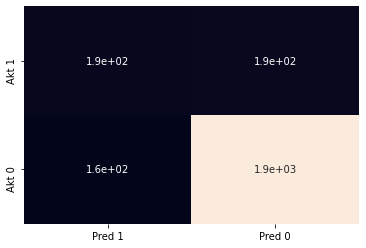

In [87]:
sns.heatmap(df_DT_CW, annot=True, cbar=False)
plt.show()

Insight : Hasil classweight model DT untuk data Online-Shop memberikan hasil yang buruk karena FPnya yang semakin besar dan nilai precision yang rendah. Dengan demikian, model ini tidak dapat digunakan sebagai machine learning data online-shop.

**Jadi, model yang akan digunakan untuk machine learning data online shop adalah model Logistic Regression Polos** karena nilai preciosion yang paling baik dan FPnya yang paling rendah.

In [88]:
# Import Model Machine Learning
joblib.dump(LR, 'Model_LR_online_shop')

['Model_LR_online_shop']

# Kesimpulan dan Saran serta simulasi Impact untuk perusahaan yang dapat anda berikan berdasarkan hasil EDA anda:

# Kesimpulan:
1. Dari hasil analisis dan insight yang telah dilakukan, permasalahan yang terjadi dalam online shop ini mengerucut pada banyaknya pelanggan yang tidak berpotensi menjadi pendapatan bagi online shop. Hal ini bisa dijadikan evaluasi ke depannya untuk melakukan improvement baik dalam hal tampilan web ataupun lainnya untuk meningkatkan persentase pelanggan menjadi pelanggan potensial untuk meningkatkan keuntungan dari online shop.
2. Hari Spesial tidak mempengaruhi niat pembeli untuk melakukan pembelanjaan online. Waktu yang berpengaruh untuk pelanggan melakukan pembelanjaan online adalah bulan September dan waktu pelanggan mengakses web kita adalah weekend.
3. Mayoritas pelanggan berpotensi berasal dari pelanggan yang sebelumnya sudah menggunakan online shop untuk berbelanja. Perlu dilakukan studi lebih lanjut mengenai alasan pelanggan tersebut meninggalkan online shop sebelumnya untuk dijadikan improvement.
4. Fokus EDA dalam hal ini berpusat pada data pelanggan berpotensi saja karena akan dilakukan machine learning pada data minoritas.

# Saran:
1. Mengadakan diskon di bulan September, khususnya weekend untuk meningkatkan daya beli pelanggan khususnya bagi pelanggan yang berpotensi (diprediksi menggunakan machine learning).
2. Sebelum memberikan diskon kepada pelanggan, agar diskon yang diberikan tepat kepada pelanggan yang diprediksi merupakan pelanggan berpotensi memberikan keuntungan maka sebaiknya data pelanggan diprediksi terlebih dahulu dengan machine learning..
Dengan melakukan prediksi dengan ML maka keuntungan perusahan akan meningkat lebih dari 10%.

In [89]:
# Membuat Halaman Data
df.to_html('data.html')